In [1]:
import pandas as pd

# Iter all annotation files and combine
FILES = [
    "../sp-week-6/annotations_alameda.jsonl",
    "../sp-week-6/annotations_louisville.jsonl",
    "../sp-week-6/annotations_oakland.jsonl",
    "../sp-week-6/annotations_seattle.jsonl",
]

all_annos = []
for f in FILES:
    # Read single annotation file
    sc_df = pd.read_json(f, orient="records", lines=True)
    
    # Iter rows breaking down span info (if there is any)
    for _, row in sc_df.iterrows():
        # Will have span(s) if its a list
        if isinstance(row.spans, list):
            # Create positive examples for each
            for span in row.spans:
                all_annos.append({
                    "text": row.text[span["start"]:span["end"]],
                    "label": "comment-intro",
                    "muni": row.meta["muni"],
                    "session_id": row.meta["session_id"],
                })
        
        # Other no span, create negative example
        else:
            all_annos.append({
                "text": row.text[0:150],
                "label": "other",
                "muni": row.meta["muni"],
                "session_id": row.meta["session_id"],
            })
    
labeled_data = pd.DataFrame(all_annos)
labeled_data

,text,label,muni,session_id
0,Santa Clara and Pacific to use but I would sa...,other,alameda,9c703cd1be77
1,You thanks. But it would probably be wise n...,other,alameda,4fc8bcbb402c
2,And I just really appreciate everything that...,other,alameda,e0a6d7924598
3,Be but both are in front of the same property...,other,alameda,183f3a7b0134
4,Each trip requires a significant investment th...,other,alameda,948e7d26bcde
...,...,...,...,...
3986,I am an employer of a Housecleaner and Im will...,other,seattle,4d8d47ae7888
3987,my name is Katie Figueroa . Im a junior at Ing...,comment-intro,seattle,e3d6d67bec42
3988,So today were going to have the two bills that...,other,seattle,b1f3bc99fdc9
3989,Seattle Transit Advisory Board for terms to Au...,other,seattle,822135139080


In [2]:
from lazy_text_classifiers import LazyTextClassifiers
from sklearn.model_selection import train_test_split
from __future__ import annotations

# Split the data into train and joint eval and test
x_train, x_eval_and_test, y_train, y_eval_and_test = train_test_split(
    labeled_data["text"],
    labeled_data["label"],
    test_size=0.6,
    random_state=12,
    stratify=labeled_data["label"],
)

# Split the eval and test into separate
x_eval, x_test, y_eval, y_test = train_test_split(
    x_eval_and_test,
    y_eval_and_test,
    test_size=0.5,
    random_state=12,
    stratify=y_eval_and_test,
)

# 60%, 20%, 20%
y_train.value_counts(), y_eval.value_counts(), y_test.value_counts()

(other            1536
 comment-intro      60
 Name: label, dtype: int64,
 other            1152
 comment-intro      45
 Name: label, dtype: int64,
 other            1153
 comment-intro      45
 Name: label, dtype: int64)

In [3]:
# Init and fit all models
ltc = LazyTextClassifiers(random_state=12)
results = ltc.fit(x_train, x_eval, y_train, y_eval)
results

Initializing model: 'tfidf-logit'
Fitting model: 'tfidf-logit'
Testing model: 'tfidf-logit'
'tfidf-logit' eval results: {'model': 'tfidf-logit', 'accuracy': 0.9699248120300752, 'balanced_accuracy': 0.6213541666666667, 'precision': 0.9665796507901772, 'recall': 0.9699248120300752, 'f1': 0.9618342028903151, 'time': 0.7245211949921213}
Initializing model: 'semantic-logit-distilbert-sst2'


No sentence-transformers model found with name /home/eva/.cache/torch/sentence_transformers/distilbert-base-uncased-finetuned-sst-2-english. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/eva/.cache/torch/sentence_transformers/distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fitting model: 'semantic-logit-distilbert-sst2'
Testing model: 'semantic-logit-distilbert-sst2'
'semantic-logit-distilbert-sst2' eval results: {'model': 'semantic-logit-distilbert-sst2', 'accuracy': 0.9933166248955723, 'balanced_accuracy': 0.9538194444444444, 'precision': 0.9933166248955723, 'recall': 0.9933166248955723, 'f1': 0.9933166248955723, 'time': 5.7088513760245405}
Initializing model: 'semantic-logit-distilbert-emotions'


No sentence-transformers model found with name /home/eva/.cache/torch/sentence_transformers/joeddav_distilbert-base-uncased-go-emotions-student. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/eva/.cache/torch/sentence_transformers/joeddav_distilbert-base-uncased-go-emotions-student were not used when initializing DistilBertModel: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fitting model: 'semantic-logit-distilbert-emotions'
Testing model: 'semantic-logit-distilbert-emotions'
'semantic-logit-distilbert-emotions' eval results: {'model': 'semantic-logit-distilbert-emotions', 'accuracy': 0.9974937343358395, 'balanced_accuracy': 0.97734375, 'precision': 0.9974761966020469, 'recall': 0.9974937343358395, 'f1': 0.9974801978501543, 'time': 4.812783918983769}


,model,accuracy,balanced_accuracy,precision,recall,f1,time
0,semantic-logit-distilbert-emotions,0.997494,0.977344,0.997476,0.997494,0.997480,4.812784
1,semantic-logit-distilbert-sst2,0.993317,0.953819,0.993317,0.993317,0.993317,5.708851
2,tfidf-logit,0.969925,0.621354,0.966580,0.969925,0.961834,0.724521


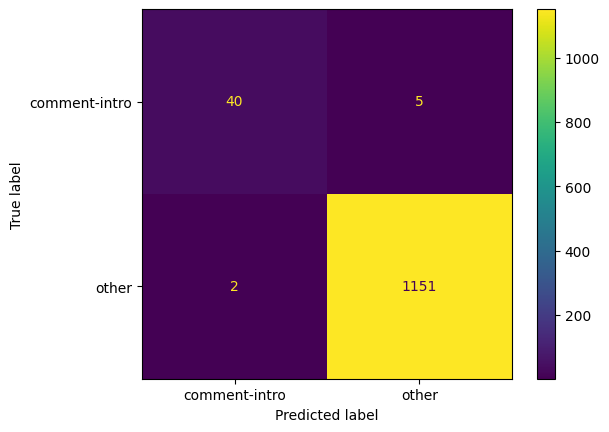

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

pred_sem_emo = ltc.fit_models["semantic-logit-distilbert-emotions"].predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, pred_sem_emo)

In [5]:
from cdp_data import datasets, CDPInstances

sessions = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2022-03-15",
    end_datetime="2022-03-16",
    raise_on_error=False,
    store_transcript=True,
)
session = sessions.iloc[0]
session

Fetching each model attached to event_ref:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/2 [00:00<?, ?it/s]

session_datetime                                2022-03-15 16:30:00+00:00
session_index                                                           0
session_content_hash    f0fb7bdf0e08fcb83125e83960013964f9b72212b38a86...
video_uri               https://video.seattle.gov/media/council/tran_0...
video_start_time                                                     None
video_end_time                                                       None
caption_uri             https://www.seattlechannel.org/documents/seatt...
external_source_id                                                   None
id                                                           d369999a1d67
key                                                  session/d369999a1d67
event                   <cdp_backend.database.models.Event object at 0...
transcript              <cdp_backend.database.models.Transcript object...
transcript_path         /home/eva/active/pit/sig-cdp/trial-pc-intro-cl...
Name: 0, dtype: object

In [6]:
from cdp_backend.pipeline.transcript_model import Transcript

with open(session.transcript_path) as open_t:
    transcript = Transcript.from_json(open_t.read())

transcript

Transcript(generator='CDP Whisper Conversion -- CDP v4.0.8 -- Whisper Model Name 'large-v2'', confidence=0.72, session_datetime='2022-03-15T09:30:00-07:00', created_datetime='2023-03-14T10:35:07.350721', sentences=[...] (n=1189), annotations=None)

In [7]:
from datetime import timedelta

window_size = 2

for s_i in range(len(transcript.sentences) - window_size + 1):
    content = " ".join([s.text for s in transcript.sentences[s_i: s_i + window_size]])
    pred = ltc.fit_models["semantic-logit-distilbert-emotions"].predict([content])
    if pred != "other":
        st = timedelta(seconds=transcript.sentences[s_i].start_time)
        print("PC INTRO")
        print(f"{st}: '{content}'")
        print()
        print()

PC INTRO
0:09:12.161834: 'Hello. My name is Robin Briggs.'


PC INTRO
0:15:49.995087: 'My name is Julia Buck. I'm a resident of District 6.'


PC INTRO
0:17:23.923761: 'Hi, this is Kashina Groves. I'm a resident of District 2 and a member of the Seattle Bicycle Advisory Board.'


PC INTRO
0:21:09.460864: 'Good morning. I'm Bob Anderton.'


PC INTRO
0:22:51.250349: 'Good morning. My name is Rachel Brown.'


PC INTRO
0:22:51.892048: 'My name is Rachel Brown. I'm the president of Seattle Subway, and I lead our policy team.'


PC INTRO
0:25:34.021281: 'Hello? Hi, my name is Clara Cantor, and I'm a community organizer for Seattle Neighborhood Greenways.'


PC INTRO
0:27:06.746769: 'Hi. I'm Don Brubeck.'


PC INTRO
0:28:40.575177: 'Hi. I go by Kaye Wolfe.'


PC INTRO
0:28:41.878628: 'I go by Kaye Wolfe. I'm a bicycle mechanic.'


PC INTRO
0:29:49.758338: 'My name is Joe Riley. And I'm a lifelong Seattle resident.'


PC INTRO
0:33:03.952462: 'Good morning. My name is Ankur, and I live in Dist

In [8]:
irr_set = pd.read_json("local-interest-groups-irr-annotation-set.jsonl", orient="records", lines=True)
irr_set

,text,meta
0,"Good morning. As you said, I'm a downtown resi...","{'muni': 'seattle', 'session_id': '6c40d8abf3c9'}"
1,Down morning. I'm chair of tree pack. It's dis...,"{'muni': 'seattle', 'session_id': '6c40d8abf3c9'}"
2,"So Doug and Andrew if you are out there, call ...","{'muni': 'seattle', 'session_id': '6c40d8abf3c9'}"
3,"Thank you. Hi, I just want to bring attention ...","{'muni': 'seattle', 'session_id': 'c6bbc7ceec24'}"
4,"Yes, I'm here. I'm unmuted, it appears. Yes. O...","{'muni': 'seattle', 'session_id': 'c6bbc7ceec24'}"
5,"Good afternoon, Council. Thank you for the cha...","{'muni': 'seattle', 'session_id': 'c6bbc7ceec24'}"
6,"Good morning, Pete her. Good morning. I'm in d...","{'muni': 'seattle', 'session_id': 'd9f30ac22162'}"
7,"Jacob, good morning. Hi. I'm Jacob sheer, Orga...","{'muni': 'seattle', 'session_id': 'd9f30ac22162'}"
8,"Good morning. I am Madison, resident of distri...","{'muni': 'seattle', 'session_id': 'd9f30ac22162'}"
9,Good morning. I want to address your agenda it...,"{'muni': 'seattle', 'session_id': '5ebad5eae48c'}"


In [29]:
window_size = 20
stride = 3
count_found = 0

import spacy
nlp = spacy.load("en_core_web_trf")

for _, row in irr_set.iterrows():
    print("ORIGINAL TEXT")
    print(row.text)
    print()
    print()
    
    words = row.text.split()
    current_classification_content = []
    for w_i in range(0, len(words) - window_size + 1, stride):
        # Get current window
        windowed_words = words[w_i: w_i + window_size]
        content = " ".join(windowed_words)
        
        # Pred
        pred = ltc.fit_models["semantic-logit-distilbert-emotions"].predict([content])
        
        # handle intro pred
        if pred == "comment-intro":
            # chop everything off except last stride
            if len(current_classification_content) != 0:
                current_classification_content.append(" ".join(windowed_words[-stride:]))
            # if first one, add it all
            else:
                current_classification_content.append(content)
        
        # handle end of pred
        else:
            # handle existing pred
            if len(current_classification_content) != 0:
                count_found += 1
                joined_content = " ".join(current_classification_content)
                doc = nlp(joined_content)
                print("PC INTRO")
                print(joined_content)
                print()
                print()
                
                encountered_person = False
                encountered_org = False
                for ent in doc.ents:
                    if ent.label_ == "PERSON" and not encountered_person:
                        print(f"{ent.label_}: '{ent.text}'")
                        encountered_person = True
                    elif ent.label_ == "ORG" and not encountered_org:
                        print(f"{ent.label_}: '{ent.text}'")
                        encountered_org = True
                    
                    if encountered_person and encountered_org:
                        break
                print()
                print()
                current_classification_content = []
    
    print("-" * 80)
    print()
            
print(count_found)

ORIGINAL TEXT
Good morning. As you said, I'm a downtown resident in district 7. I'm Commenting today on Sdci and the committee's work program for changes to land use and design we view. We ask this work be done with public engagement. I'd like to Commentfor a great job. Public forums need to be the standard for design review.


--------------------------------------------------------------------------------

ORIGINAL TEXT
Down morning. I'm chair of tree pack. It's disappointing to not see updating the tree ordinance as a priority in 2021 in their presentation which was put on the Website it is not surprising, however, considering Sdci's history on tree protection. Rumor has it there will not be a tree ordinance update this year. It's time to end this repeated delay by Sdci in presenting the Seattle city council with an updated Ordnance.


--------------------------------------------------------------------------------

ORIGINAL TEXT
So Doug and Andrew if you are out there, call in to t